The following example shows how to train a model. Get a list of training data csv file in the selected folder. Lessons learned so far:
- Training result is very sensitive to normalization. The normalization approach based on mean and variance does not work very well. Still need to manually set mean and variance.
- t-sne plot of adapter trace is an important flag of training result. 
- h net does not have to descent because phi net training strives to make it rise, while h net training itself tries to lower the loss
- Increase the h training frequency to fight against rising h 
- Increase alpha to push domain info to adapter
- Increase number of features to minimize MSE loss.
- ocassional small spike in cross entropy loss is possibly a sign that phi net become further domain invariant and may not be bad.
- at the late stage of training while both mse loss and cross entropy loss converge. May need to train h net every step to refine the optimization direction.
- Do not need to select the model at the end epoch. Select the epoch when the loss is reasonably low and stable. 
- RMS is a good indicator because it matches the least square form of loss function
- When the residual force is small, e.g. training disturbance force compensated by BEMT, disturbance normalization should scale up the label for better learning. 

Existing problem:
- The more classes, the harder to train. The difficulty comes from instability of loss_f and loss_c. alpha is hard to tune.
- t-sne gets worse as epoch grows and the cross entropy loss remains the same. 

In [1]:
import os
import matplotlib.pyplot as plt

import training_manager

current_dir = os.getcwd()
training_subfolder = "wind_near_wall_bemt_fitting"
# training_subfolder = "nf_training_back2back"
# validation_subfolder = "nf_validation_back2back"
validation_subfolder = "wind_near_wall_bemt_fitting_validation"

def generate_data_list(subfolder):
    """
    Generate a list of data files in the specified subfolder.
    """
    folder_path = os.path.join(os.path.dirname(current_dir), "data", "training", subfolder)
    file_names = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

    # Filter out files that do not end with .csv
    file_names = [f for f in file_names if f.endswith('.csv')]
    # add subfolder to the file names
    data_list = [os.path.join(subfolder, f) for f in file_names]
    return data_list

data_list = generate_data_list(training_subfolder)
print("Training Data List:")
for data in data_list:
    print(data)

validation_list = generate_data_list(validation_subfolder)
print("\nValidation Data List:")
for data in validation_list:
    print(data)

path1 = os.path.join(training_subfolder, "input_label_map_disturbance_force_label.yaml")

Training Data List:
wind_near_wall_bemt_fitting\test_wind_near_wall_x0_0_y0_0_z0_0_d100_4_fitting.csv
wind_near_wall_bemt_fitting\test_wind_near_wall_x0_0_y0_0_z5_0_d100_4_fitting.csv
wind_near_wall_bemt_fitting\test_wind_near_wall_x0_0_y0_0_zn5_0_d100_4_fitting.csv
wind_near_wall_bemt_fitting\test_wind_near_wall_xn3_0_y0_0_z0_0_d100_4_fitting.csv
wind_near_wall_bemt_fitting\test_wind_near_wall_xn3_0_y0_0_z5_0_d100_4_fitting.csv
wind_near_wall_bemt_fitting\test_wind_near_wall_xn3_0_y0_0_zn5_0_d100_4_fitting.csv

Validation Data List:
wind_near_wall_bemt_fitting_validation\test_wind_near_wall_x0_0_y0_0_z10_0_d0_5_validation_no_bemt.csv
wind_near_wall_bemt_fitting_validation\test_wind_near_wall_x0_0_y0_0_z1_0_d0_5_validation_no_bemt.csv
wind_near_wall_bemt_fitting_validation\test_wind_near_wall_x0_0_y0_0_z4_0_d0_5_validation_no_bemt.csv
wind_near_wall_bemt_fitting_validation\test_wind_near_wall_x0_0_y0_0_zn10_0_d0_5_validation_no_bemt.csv
wind_near_wall_bemt_fitting_validation\test_wind_

- Make sure the input_label_map_disturbance_force_label.yaml is in the selected folder. This yaml defines which fields are model inputs and which fields are data labels. 
- Make sure the column_map.yaml is in the selected folder. This yaml maps data fields to the corresponding column in the csv files. This file can be auto-generated by `Simulation\simulation\training_data_user_guide.ipynb`
- If this is the first time to train on this data. The script will normalize the data and save the normalization parameters into a file.

Setting up data factory...
Loading normalization params file from
..\data\training\wind_near_wall_bemt_fitting\normalization_params.yaml
Using 1501 samples from the dataset for training from source file: wind_near_wall_bemt_fitting\test_wind_near_wall_x0_0_y0_0_z0_0_d100_4_fitting.csv
Using 1501 samples from the dataset for training from source file: wind_near_wall_bemt_fitting\test_wind_near_wall_x0_0_y0_0_z5_0_d100_4_fitting.csv
Using 1501 samples from the dataset for training from source file: wind_near_wall_bemt_fitting\test_wind_near_wall_x0_0_y0_0_zn5_0_d100_4_fitting.csv
Using 1501 samples from the dataset for training from source file: wind_near_wall_bemt_fitting\test_wind_near_wall_xn3_0_y0_0_z0_0_d100_4_fitting.csv
Using 1501 samples from the dataset for training from source file: wind_near_wall_bemt_fitting\test_wind_near_wall_xn3_0_y0_0_z5_0_d100_4_fitting.csv
Using 1501 samples from the dataset for training from source file: wind_near_wall_bemt_fitting\test_wind_near_wall_

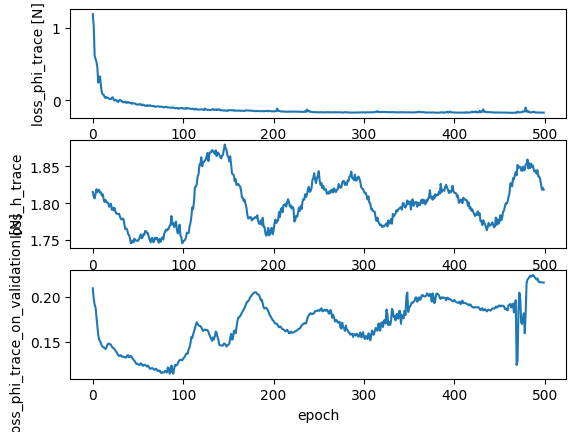

In [2]:
# use the data from previous section to train the model

factory = training_manager.PipelineFactory(True)
manager = factory.make_training_pipeline()
manager.set_up(
    training_data_menu=data_list,
    # training_data_menu=data_list[:4],    # use small data list for quick testing
    validation_data_menu=validation_list[-1:],
    input_label_map_file=path1,
    can_inspect_data=False
)
plt.show() 
manager.train()

plt.show()  

Inspect data in the data list.

Plotting t-SNE of a_trace...


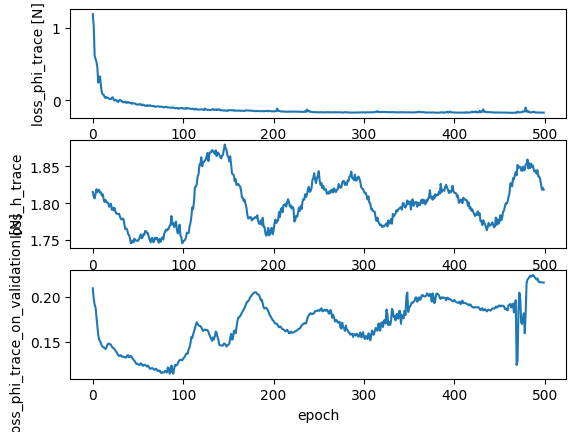

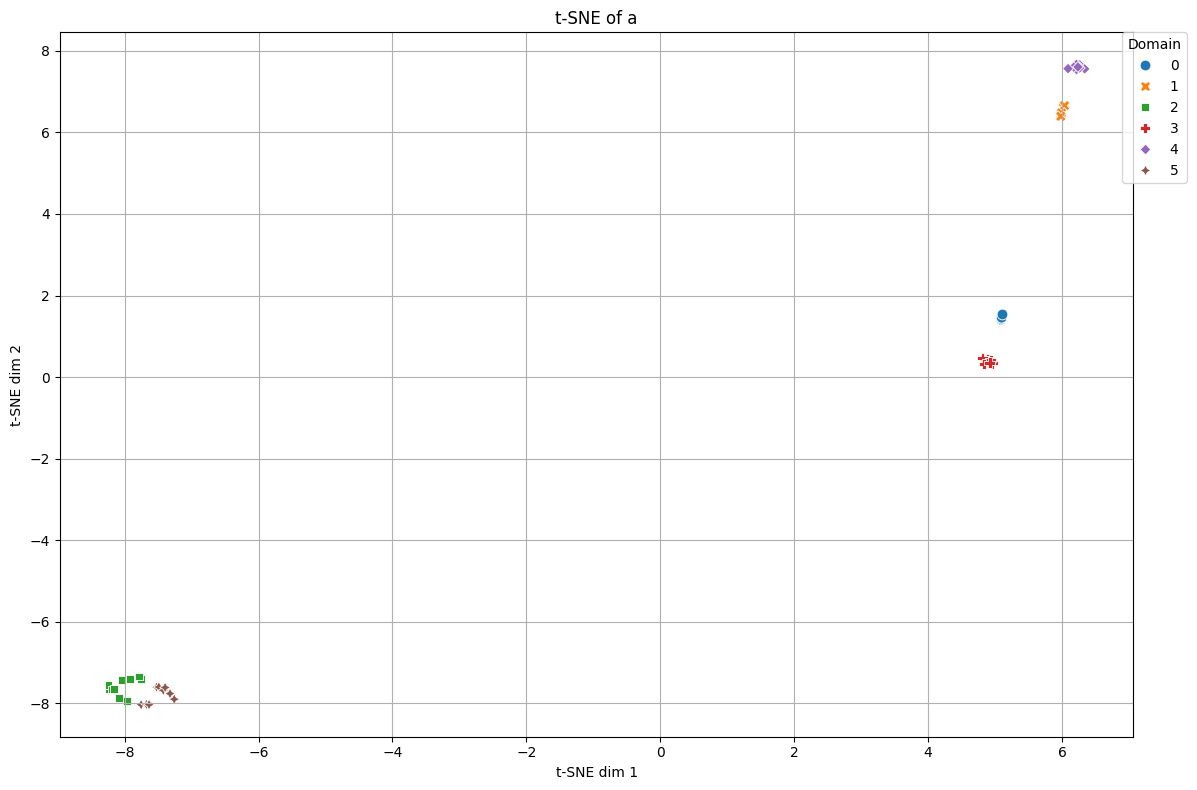

In [3]:
# trainer_instance.inspect_data(data_list[:2])
manager.show_result_only()

After training, we can save the model in the following way.

In [4]:
model_name = training_subfolder
manager.save_model(model_name)

Model saved to model\wind_near_wall_bemt_fitting.pth


Test the model using the test set.

test Data List:
wind_near_wall_bemt_fitting_validation\test_wind_near_wall_x0_0_y0_0_z10_0_d0_5_validation_no_bemt.csv
wind_near_wall_bemt_fitting_validation\test_wind_near_wall_x0_0_y0_0_z1_0_d0_5_validation_no_bemt.csv
wind_near_wall_bemt_fitting_validation\test_wind_near_wall_x0_0_y0_0_z4_0_d0_5_validation_no_bemt.csv
wind_near_wall_bemt_fitting_validation\test_wind_near_wall_x0_0_y0_0_zn10_0_d0_5_validation_no_bemt.csv
wind_near_wall_bemt_fitting_validation\test_wind_near_wall_x0_0_y0_0_zn1_0_d0_5_validation_no_bemt.csv
wind_near_wall_bemt_fitting_validation\test_wind_near_wall_x0_0_y0_0_zn4_0_d0_5_validation_no_bemt.csv
wind_near_wall_bemt_fitting_validation\test_wind_near_wall_xn2_0_y0_0_z10_0_d0_5_validation_no_bemt.csv
wind_near_wall_bemt_fitting_validation\test_wind_near_wall_xn2_0_y0_0_z1_0_d0_5_validation_no_bemt.csv
wind_near_wall_bemt_fitting_validation\test_wind_near_wall_xn2_0_y0_0_z4_0_d0_5_validation_no_bemt.csv
wind_near_wall_bemt_fitting_validation\test_wind_near_wal

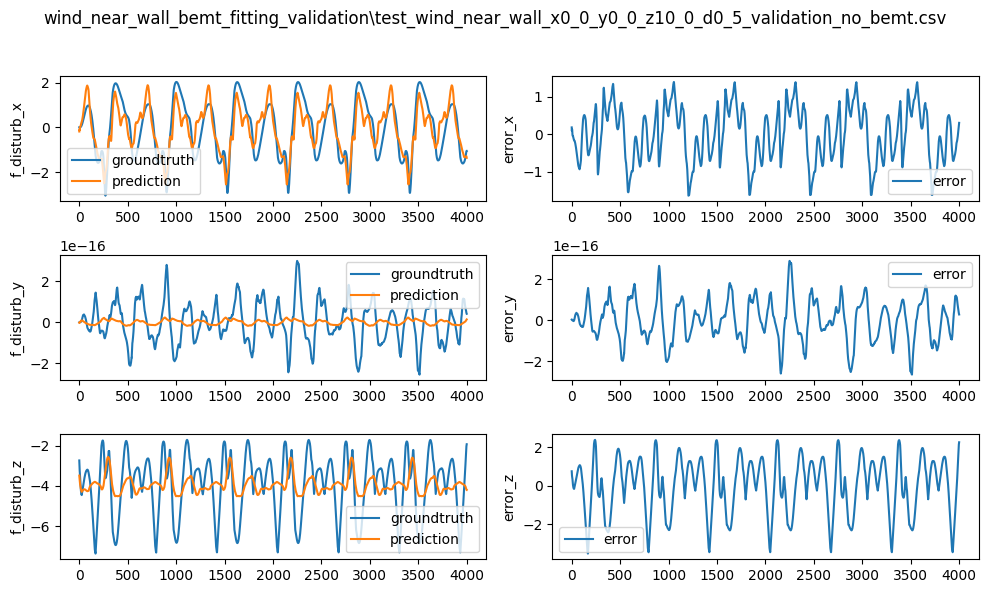

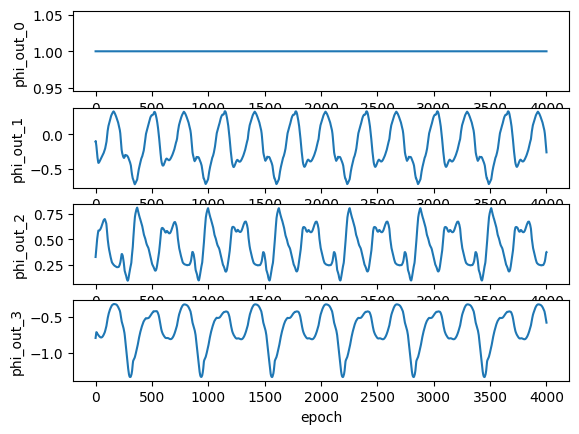

phi_out: tensor([[ 1.0000,  0.0042, -0.0660, -0.3191],
        [ 1.0000, -0.0026, -0.0603, -0.3199],
        [ 1.0000, -0.0085, -0.0556, -0.3209],
        ...,
        [ 1.0000,  0.1586, -0.1768, -0.2560],
        [ 1.0000,  0.1566, -0.1778, -0.2621],
        [ 1.0000,  0.1544, -0.1788, -0.2683]])
a = tensor([[ 4.0717e-02,  2.2605e-19,  3.0486e-01],
        [-2.9751e-01,  1.0905e-18, -2.0383e+00],
        [-5.3628e-02, -7.3729e-19, -2.3198e+00],
        [ 1.4435e-01,  3.4515e-19,  4.6261e-01]])


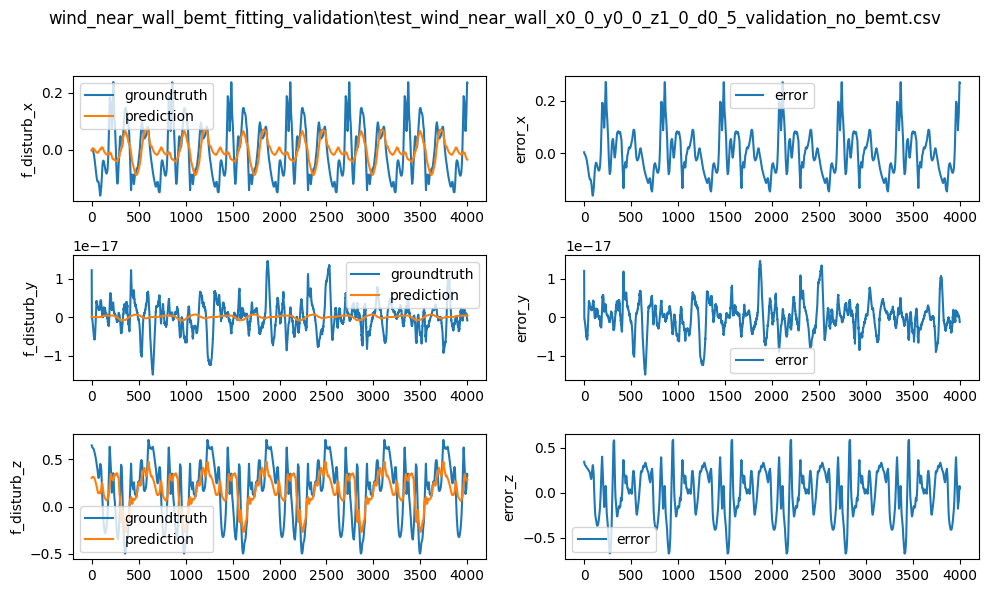

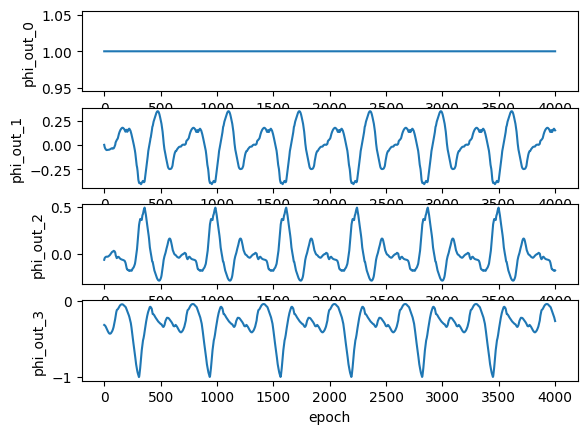

phi_out: tensor([[ 1.0000, -0.1642,  0.1412, -0.5143],
        [ 1.0000, -0.1641,  0.1444, -0.5089],
        [ 1.0000, -0.1637,  0.1465, -0.5040],
        ...,
        [ 1.0000, -0.0191, -0.0313, -0.3953],
        [ 1.0000, -0.0283, -0.0262, -0.4078],
        [ 1.0000, -0.0390, -0.0211, -0.4199]])
a = tensor([[-3.2995e-01,  1.4865e-19,  9.2411e-01],
        [ 1.0612e+00,  2.3145e-18, -2.4488e+00],
        [ 1.0216e+00,  2.4648e-18, -3.9087e+00],
        [-5.3830e-01,  1.2154e-18,  2.8413e+00]])


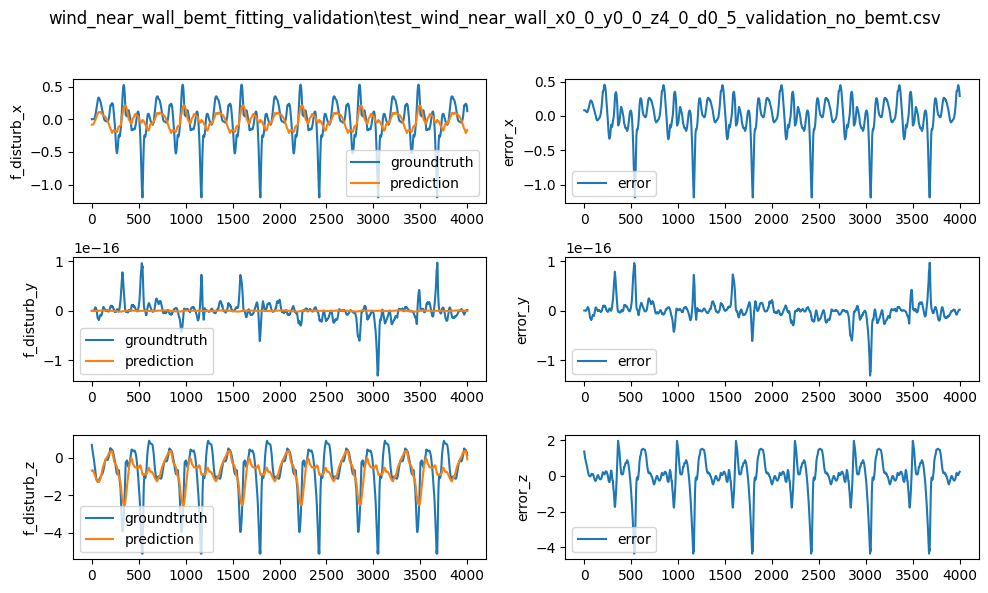

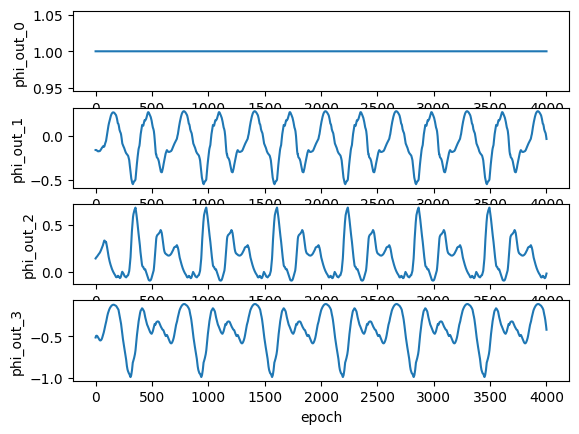

phi_out: tensor([[ 1.0000, -0.7124,  0.5405, -0.3049],
        [ 1.0000, -0.7159,  0.5431, -0.3003],
        [ 1.0000, -0.7194,  0.5457, -0.2956],
        ...,
        [ 1.0000, -0.6809,  0.5258, -0.3352],
        [ 1.0000, -0.6816,  0.5233, -0.3373],
        [ 1.0000, -0.6822,  0.5207, -0.3392]])
a = tensor([[-1.4126e+00, -2.9409e-18,  1.7060e+00],
        [-6.9049e-01, -8.1053e-19,  4.7294e+00],
        [ 1.0155e+00,  8.7963e-18,  4.4078e-02],
        [-1.1933e+00,  7.3897e-18, -4.8417e+00]])


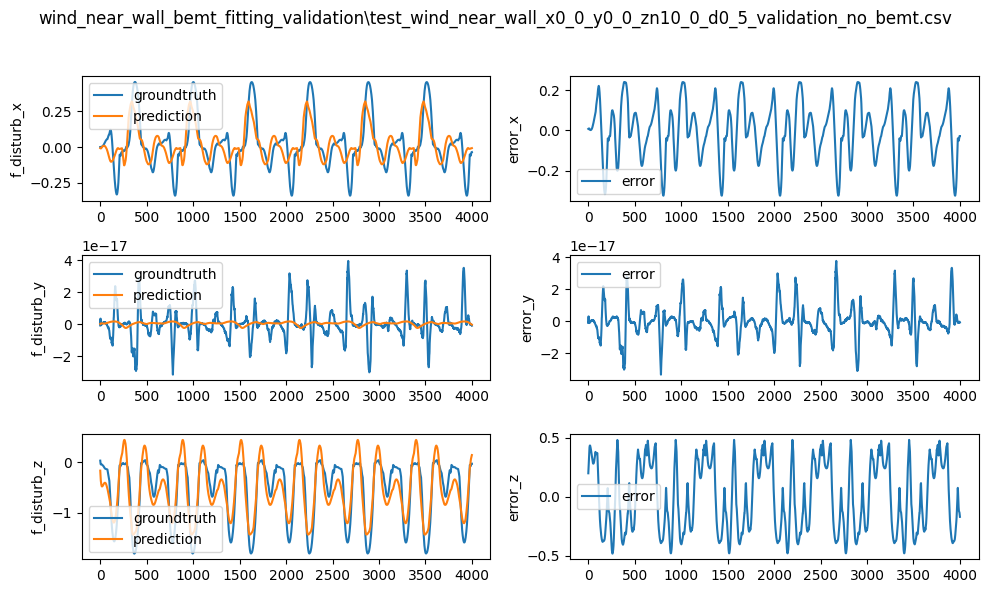

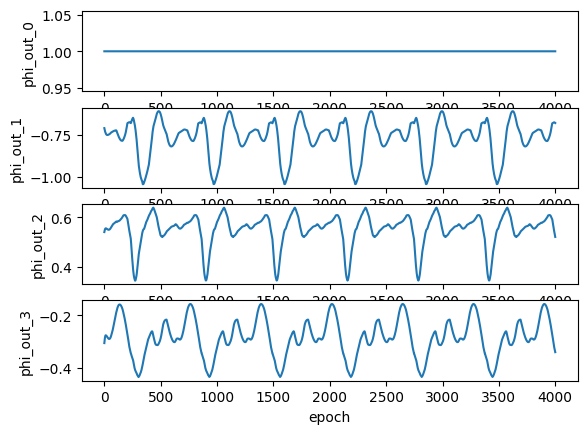

phi_out: tensor([[ 1.0000e+00,  2.4720e-03, -1.0845e-01, -2.2423e-01],
        [ 1.0000e+00,  7.3559e-04, -1.0824e-01, -2.2378e-01],
        [ 1.0000e+00, -1.0851e-03, -1.0842e-01, -2.2371e-01],
        ...,
        [ 1.0000e+00,  1.5827e-01, -9.9906e-02, -2.3796e-01],
        [ 1.0000e+00,  1.5741e-01, -1.0251e-01, -2.4016e-01],
        [ 1.0000e+00,  1.5642e-01, -1.0441e-01, -2.4308e-01]])
a = tensor([[ 1.3544e-02, -1.9655e-18, -7.7673e-01],
        [ 1.5480e-01, -4.5524e-19, -4.9955e+00],
        [ 8.2995e-01, -1.3294e-18, -5.7993e+00],
        [ 5.0380e-02, -5.5838e-18,  1.7134e-01]])


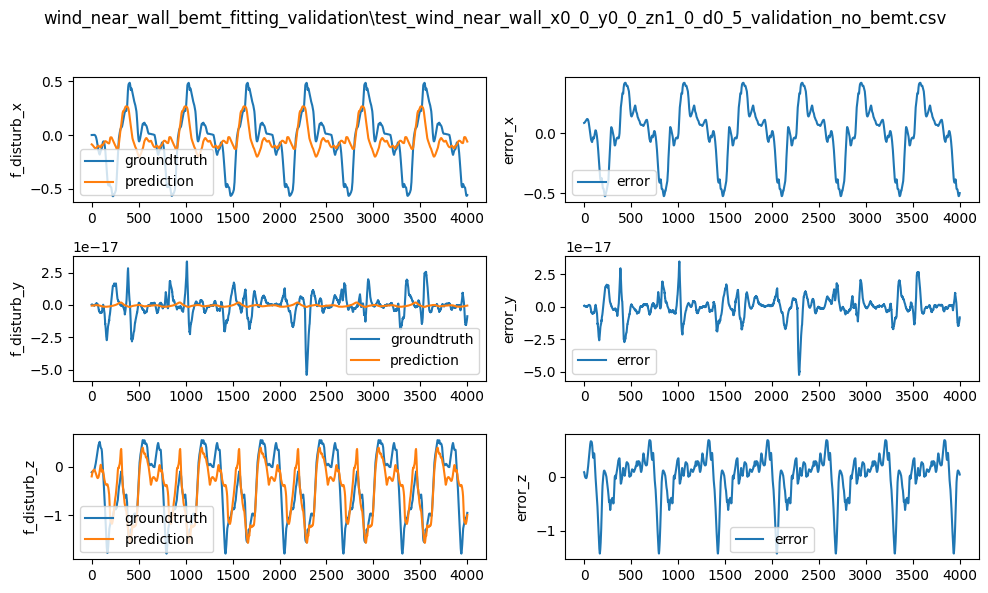

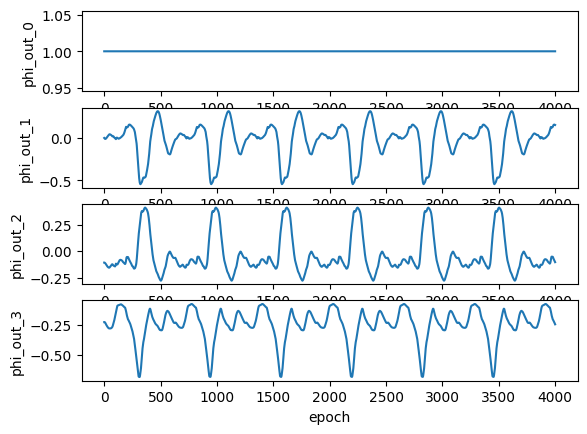

phi_out: tensor([[ 1.0000, -0.2599,  0.1983, -0.2237],
        [ 1.0000, -0.2616,  0.1998, -0.2226],
        [ 1.0000, -0.2630,  0.2003, -0.2219],
        ...,
        [ 1.0000, -0.1227,  0.0732, -0.2694],
        [ 1.0000, -0.1219,  0.0691, -0.2707],
        [ 1.0000, -0.1208,  0.0640, -0.2720]])
a = tensor([[-9.8413e-01,  1.8029e-20, -1.0419e+00],
        [ 1.5071e-01, -5.7783e-19,  4.2427e+00],
        [ 1.9297e+00,  4.2037e-19,  9.5790e-01],
        [-3.0849e+00,  1.1869e-18, -3.8419e+00]])


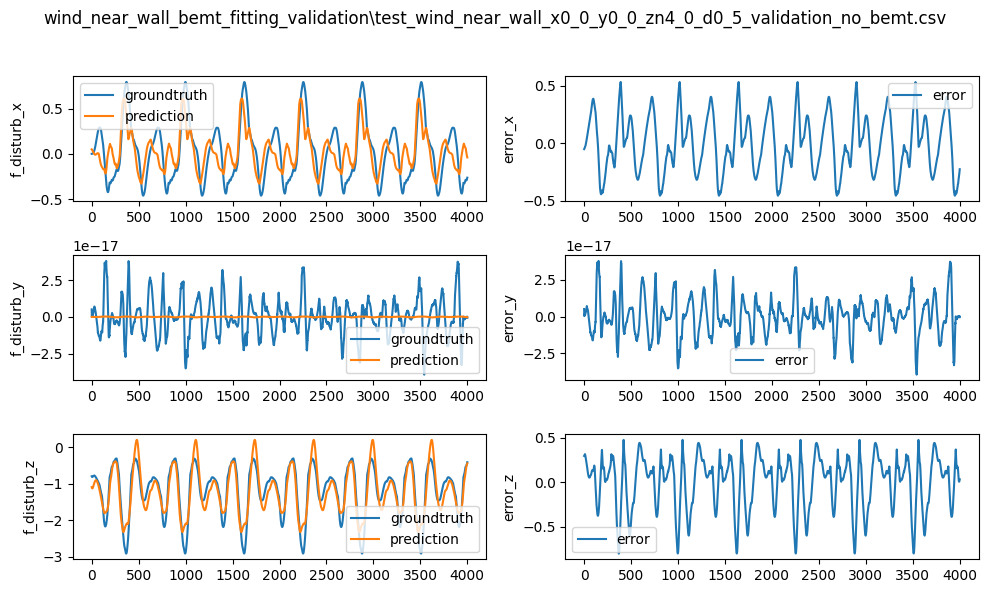

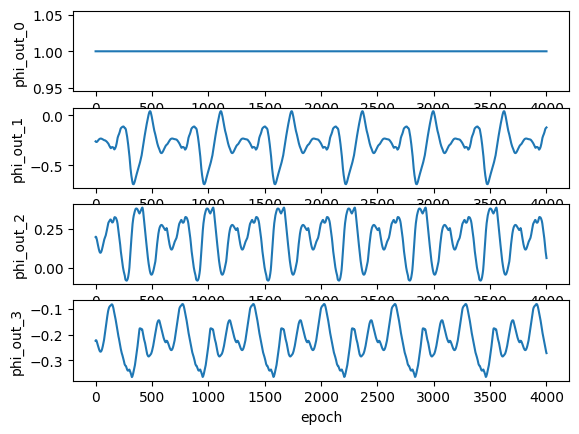

phi_out: tensor([[ 1.0000, -0.1540,  0.2425, -0.7999],
        [ 1.0000, -0.1573,  0.2531, -0.7957],
        [ 1.0000, -0.1578,  0.2657, -0.7918],
        ...,
        [ 1.0000, -0.3630,  0.3582, -0.6476],
        [ 1.0000, -0.3671,  0.3515, -0.6525],
        [ 1.0000, -0.3720,  0.3449, -0.6577]])
a = tensor([[-6.6039e+00, -1.4915e-17, -3.3878e+00],
        [ 5.0791e+00,  4.4810e-16,  4.2116e+00],
        [ 6.2710e+00, -1.8111e-16, -3.0297e+00],
        [-7.0922e+00, -2.6561e-16, -3.1342e+00]])


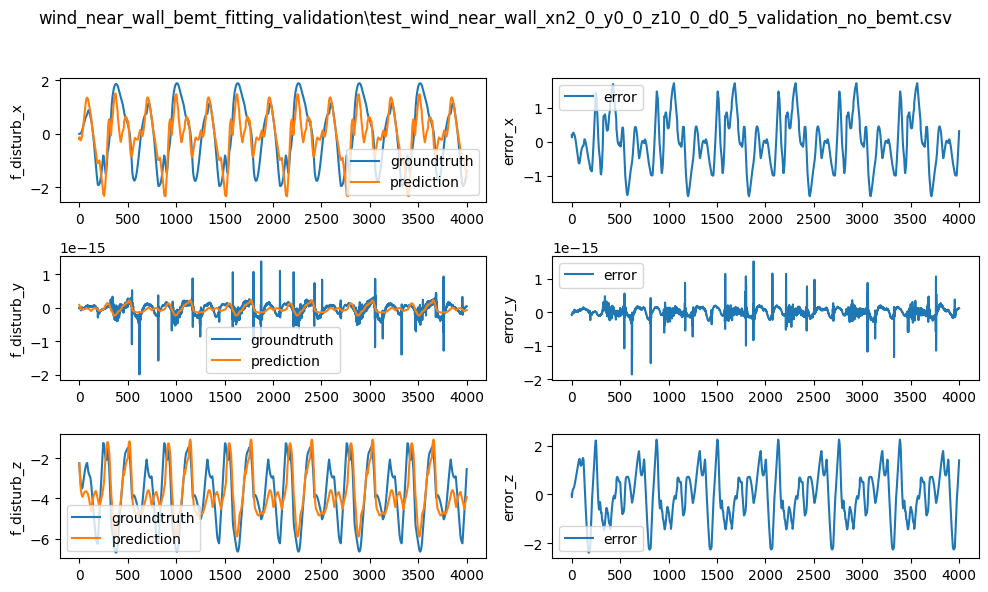

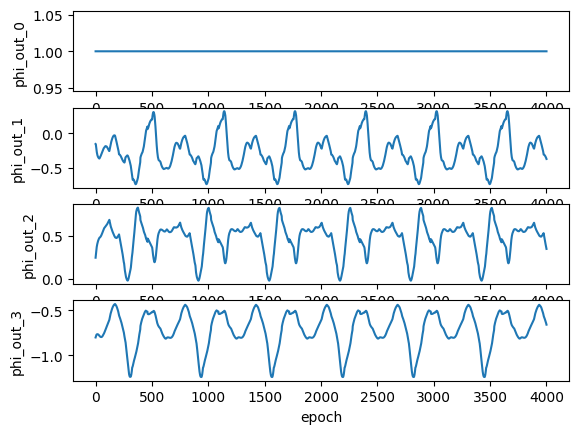

phi_out: tensor([[ 1.0000e+00,  1.3820e-02, -2.1810e-01, -3.3055e-01],
        [ 1.0000e+00,  6.7778e-03, -2.1699e-01, -3.2827e-01],
        [ 1.0000e+00,  8.9398e-04, -2.1581e-01, -3.2696e-01],
        ...,
        [ 1.0000e+00,  1.6032e-01, -3.5509e-01, -3.1636e-01],
        [ 1.0000e+00,  1.6137e-01, -3.5663e-01, -3.2253e-01],
        [ 1.0000e+00,  1.6219e-01, -3.5815e-01, -3.2875e-01]])
a = tensor([[-5.0635e-02, -1.7126e-17, -1.7192e-01],
        [-2.0725e-01, -3.1719e-17, -2.3329e+00],
        [-2.2856e-01, -5.4894e-17, -2.7922e+00],
        [-1.0079e-01, -8.3198e-18,  2.0425e-01]])


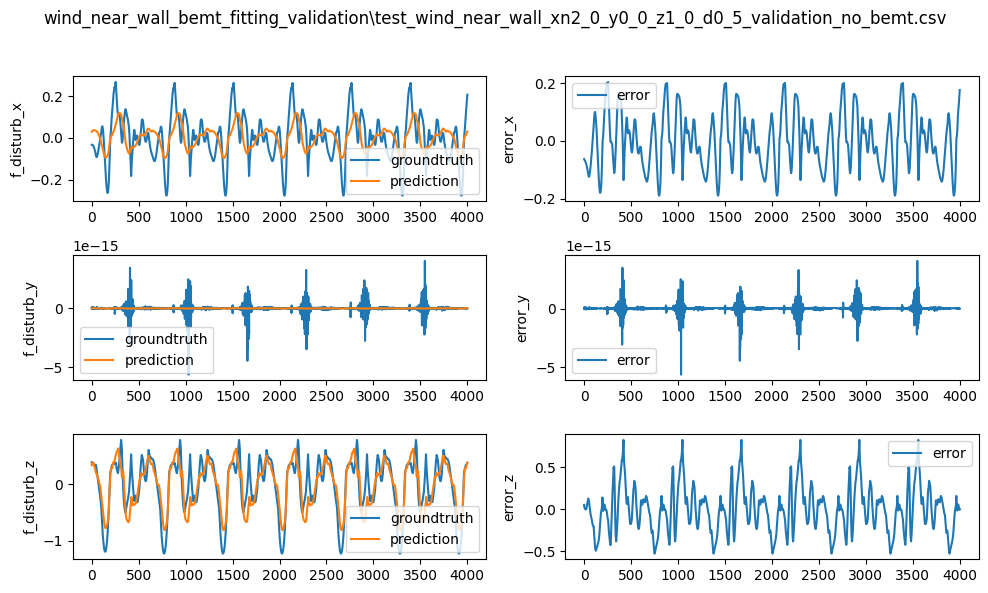

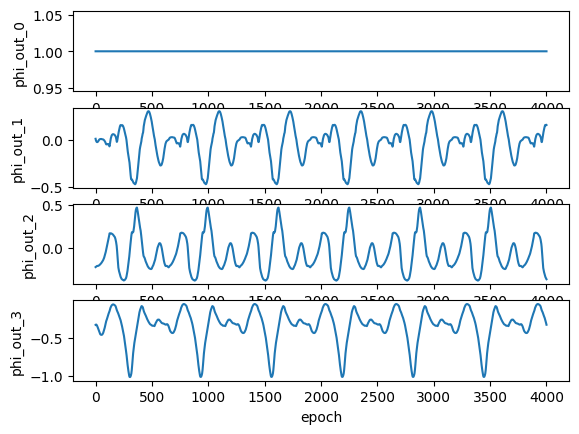

phi_out: tensor([[ 1.0000, -0.1394, -0.0104, -0.4686],
        [ 1.0000, -0.1404, -0.0068, -0.4609],
        [ 1.0000, -0.1414, -0.0038, -0.4545],
        ...,
        [ 1.0000, -0.0917, -0.1434, -0.4072],
        [ 1.0000, -0.0952, -0.1478, -0.4137],
        [ 1.0000, -0.0976, -0.1537, -0.4205]])
a = tensor([[-1.2591e-01, -2.7352e-18,  9.1129e-01],
        [ 3.6387e-01,  1.7422e-18,  3.0441e-01],
        [ 2.9715e-01,  5.9006e-18, -1.9109e+00],
        [-1.7767e-01, -3.9685e-18,  2.8444e+00]])


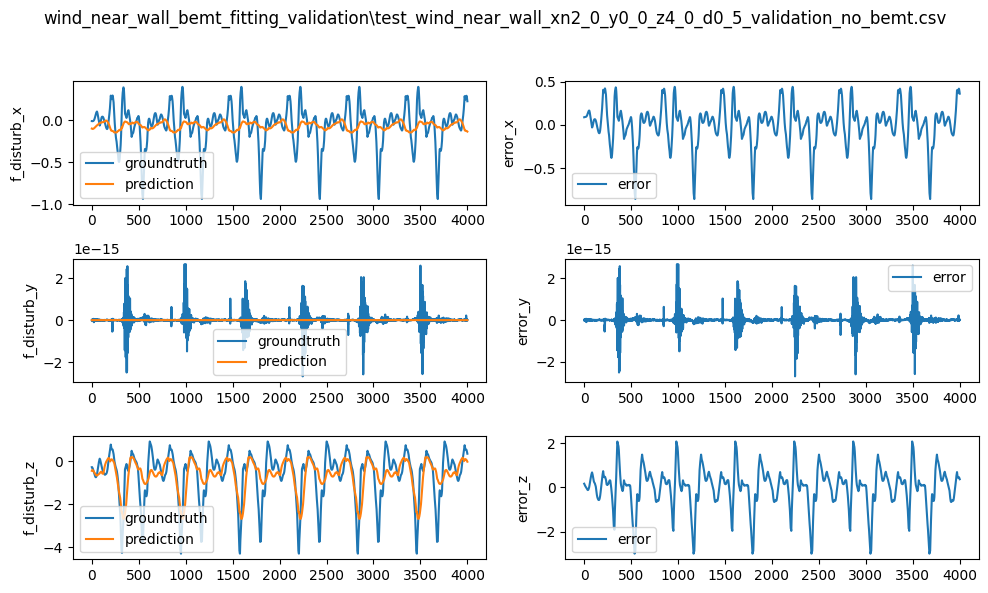

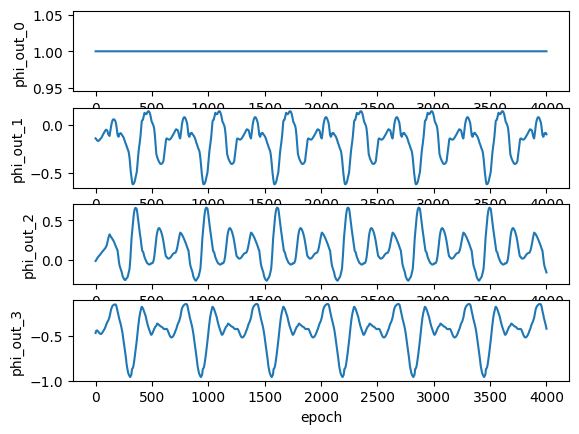

phi_out: tensor([[ 1.0000, -0.6952,  0.5499, -0.3008],
        [ 1.0000, -0.7006,  0.5536, -0.2943],
        [ 1.0000, -0.7051,  0.5566, -0.2889],
        ...,
        [ 1.0000, -0.6401,  0.5241, -0.3434],
        [ 1.0000, -0.6379,  0.5182, -0.3477],
        [ 1.0000, -0.6357,  0.5123, -0.3520]])
a = tensor([[-1.1406e+00, -2.6654e-18,  1.2308e+00],
        [-1.0755e+00, -7.9722e-18,  4.2540e+00],
        [ 2.6815e-01, -9.8435e-18,  6.5485e-01],
        [-7.0650e-01,  7.3160e-18, -3.7937e+00]])


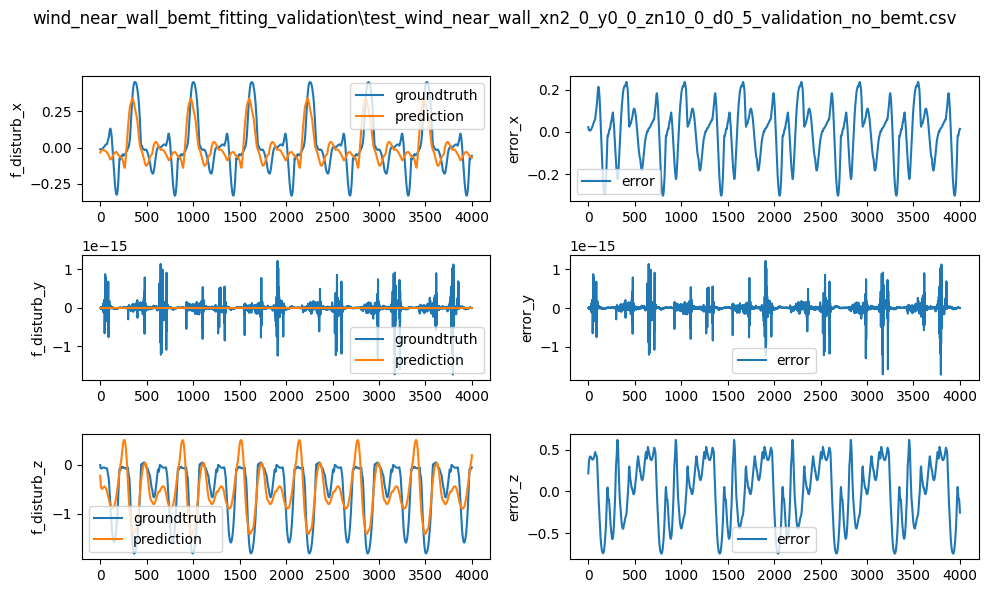

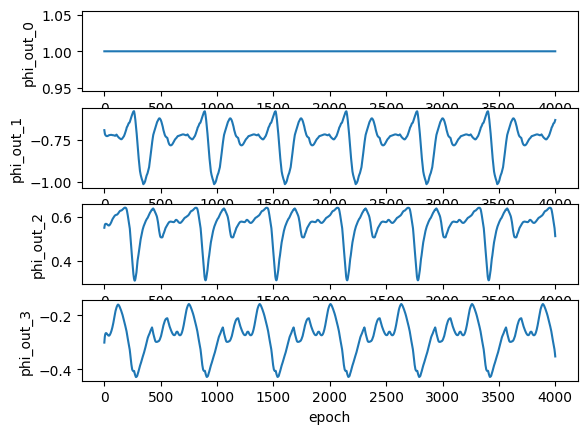

phi_out: tensor([[ 1.0000,  0.0669, -0.2381, -0.2629],
        [ 1.0000,  0.0636, -0.2381, -0.2621],
        [ 1.0000,  0.0608, -0.2383, -0.2617],
        ...,
        [ 1.0000,  0.2224, -0.3074, -0.2994],
        [ 1.0000,  0.2231, -0.3112, -0.3024],
        [ 1.0000,  0.2236, -0.3151, -0.3053]])
a = tensor([[-1.1384e-01, -2.9799e-18, -1.0573e+00],
        [-3.2765e-01,  7.6641e-18, -4.7897e+00],
        [ 6.2669e-02,  1.2655e-17, -4.8467e+00],
        [-2.8326e-01, -1.0571e-17,  1.1872e-01]])


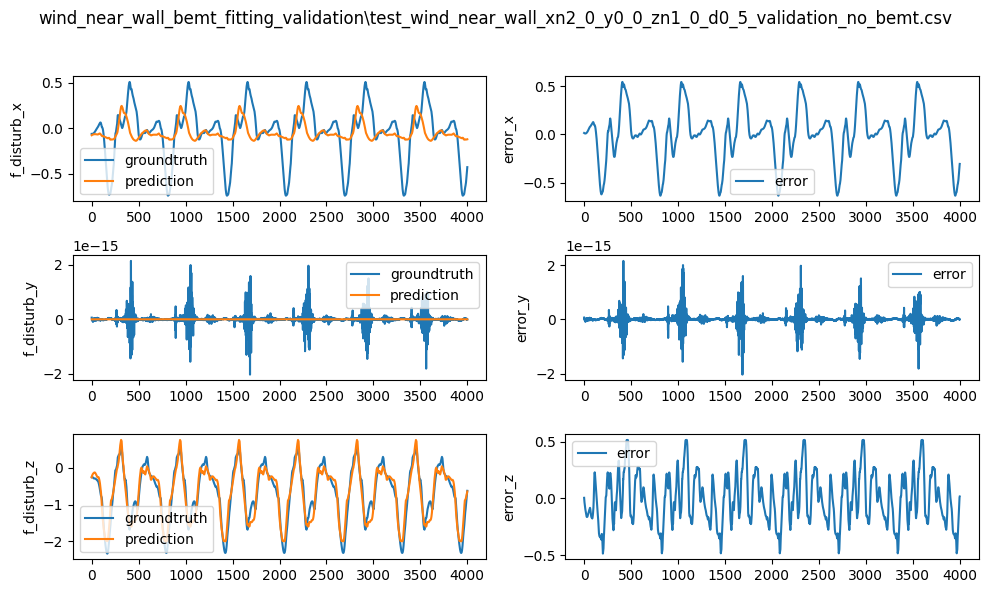

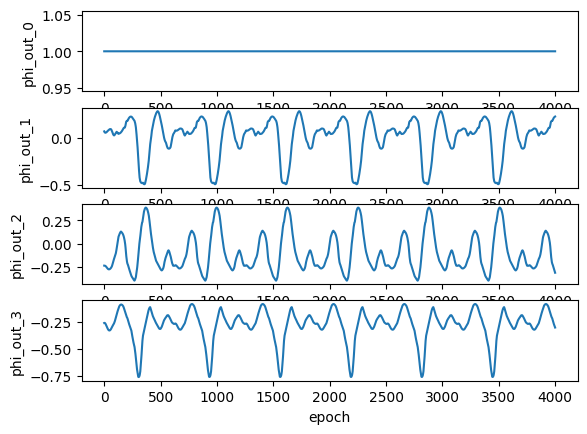

phi_out: tensor([[ 1.0000, -0.1983,  0.0961, -0.2305],
        [ 1.0000, -0.2003,  0.0959, -0.2294],
        [ 1.0000, -0.2018,  0.0953, -0.2286],
        ...,
        [ 1.0000, -0.0490, -0.0142, -0.2987],
        [ 1.0000, -0.0475, -0.0209, -0.3006],
        [ 1.0000, -0.0461, -0.0280, -0.3027]])
a = tensor([[-7.9152e-01, -8.1500e-18, -1.6836e+00],
        [-6.4036e-01,  9.6004e-18,  3.7136e+00],
        [ 1.0737e+00,  2.3282e-17,  8.6053e-01],
        [-1.9616e+00, -1.4598e-17, -5.0711e+00]])


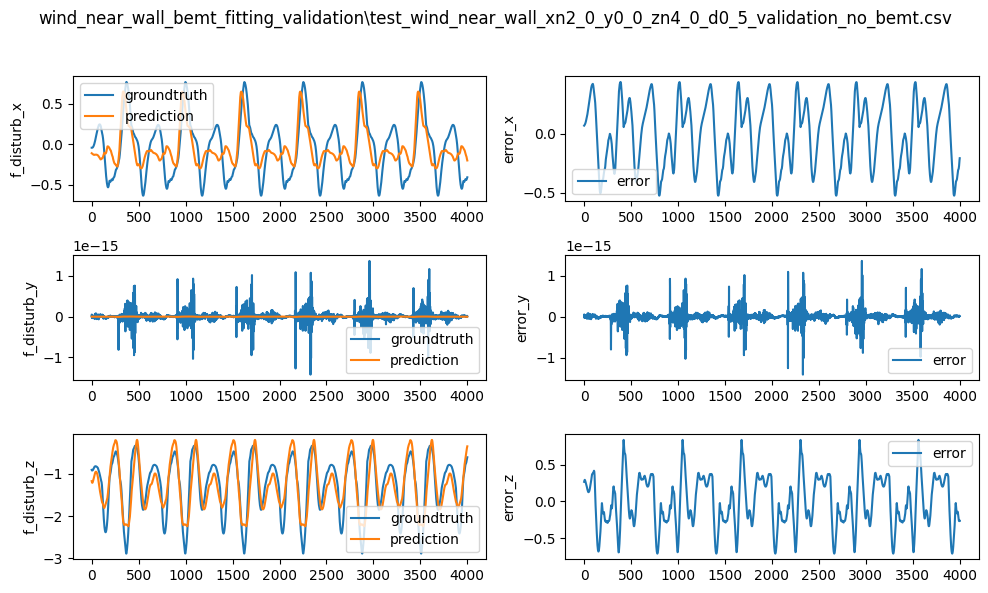

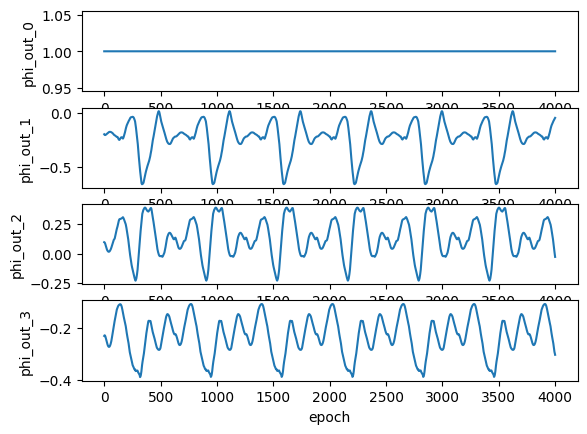

phi_out: tensor([[ 1.0000, -0.1583,  0.0860, -0.8222],
        [ 1.0000, -0.1644,  0.0922, -0.8183],
        [ 1.0000, -0.1695,  0.0989, -0.8145],
        ...,
        [ 1.0000, -0.3241,  0.0767, -0.6517],
        [ 1.0000, -0.3281,  0.0702, -0.6572],
        [ 1.0000, -0.3322,  0.0638, -0.6628]])
a = tensor([[-5.6254e+00,  6.5334e-17, -2.8654e+00],
        [ 4.6380e+00,  5.3014e-16,  3.2730e+00],
        [ 5.5123e+00, -1.6064e-16, -2.9779e+00],
        [-7.2523e+00, -1.8474e-16, -1.3950e+00]])


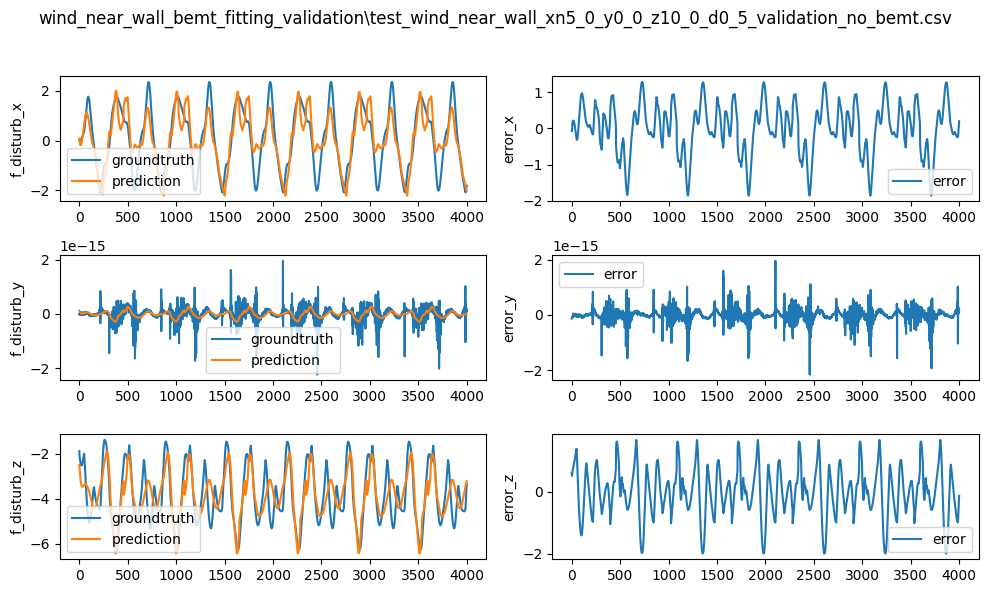

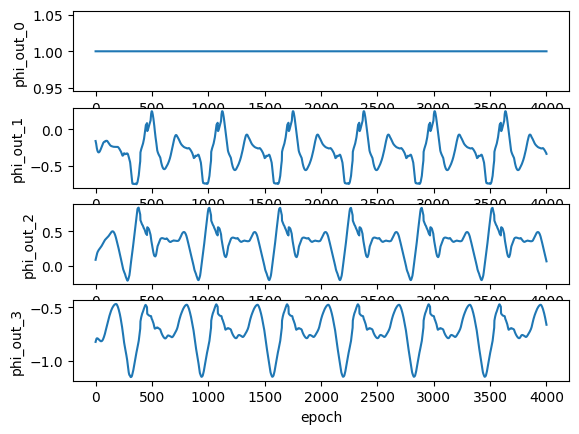

phi_out: tensor([[ 1.0000,  0.0707, -0.4672, -0.4271],
        [ 1.0000,  0.0606, -0.4619, -0.4273],
        [ 1.0000,  0.0520, -0.4571, -0.4280],
        ...,
        [ 1.0000,  0.2420, -0.6766, -0.4092],
        [ 1.0000,  0.2420, -0.6802, -0.4156],
        [ 1.0000,  0.2420, -0.6837, -0.4216]])
a = tensor([[-3.5840e-01,  1.1164e-17, -1.9676e+00],
        [ 9.9421e-01, -7.9631e-17, -2.4799e+00],
        [ 6.8422e-01, -2.8654e-17, -2.6330e+00],
        [-1.3231e+00,  4.8057e-17, -6.0067e-01]])


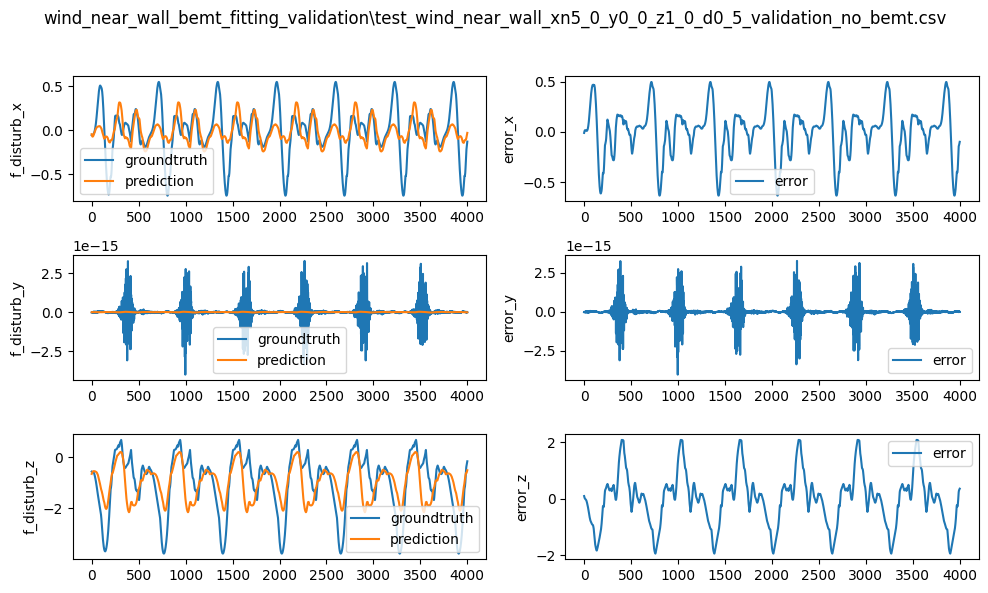

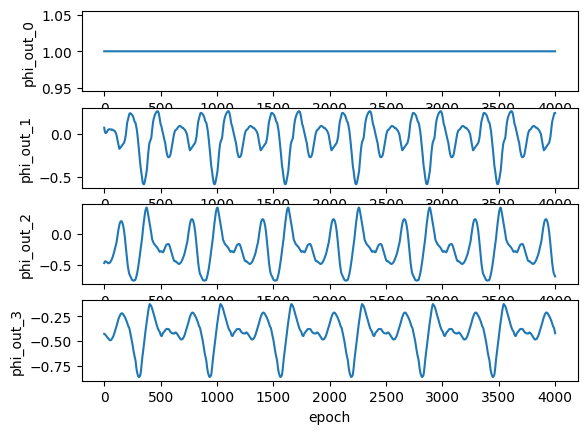

phi_out: tensor([[ 1.0000, -0.1668, -0.2055, -0.5276],
        [ 1.0000, -0.1801, -0.1968, -0.5229],
        [ 1.0000, -0.1887, -0.1886, -0.5182],
        ...,
        [ 1.0000, -0.0672, -0.3914, -0.4875],
        [ 1.0000, -0.0673, -0.3985, -0.4931],
        [ 1.0000, -0.0666, -0.4049, -0.4974]])
a = tensor([[-4.1847e-01,  2.5836e-17, -2.9516e-01],
        [ 2.2144e+00, -9.9248e-18,  1.5171e+00],
        [ 1.8826e+00, -1.6961e-17,  6.4666e-01],
        [-1.6552e+00,  6.8716e-17,  1.9737e+00]])


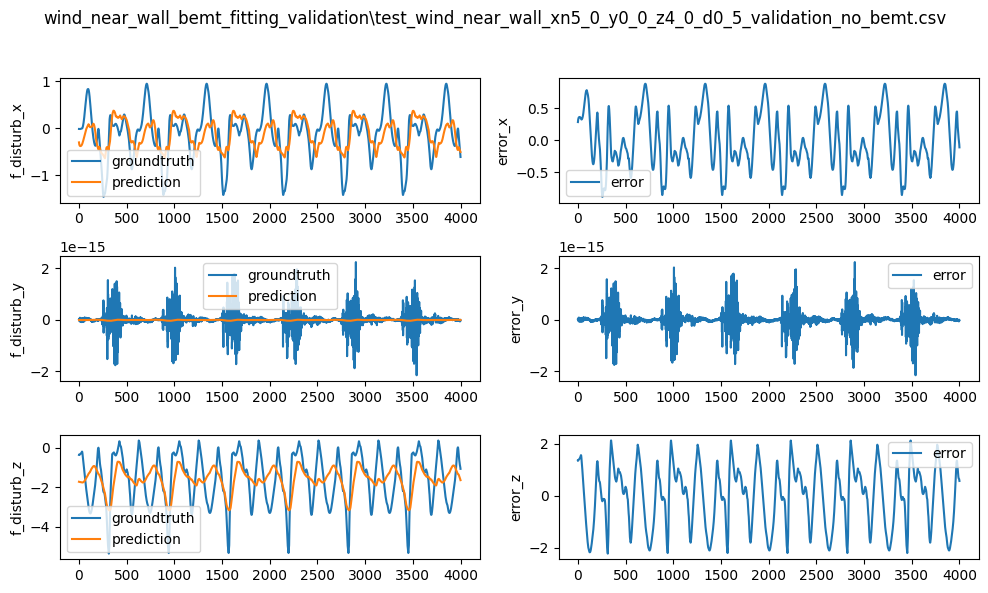

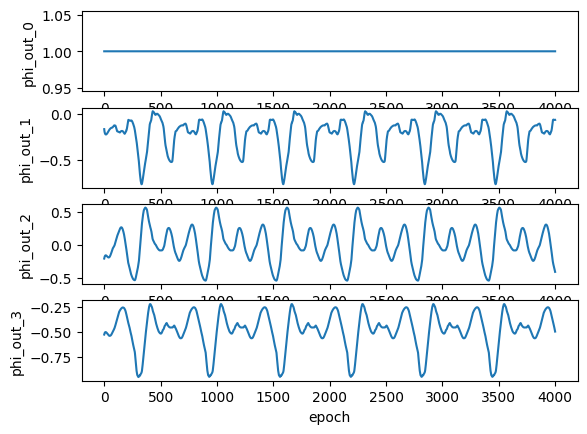

phi_out: tensor([[ 1.0000, -0.5597,  0.4535, -0.3310],
        [ 1.0000, -0.5686,  0.4608, -0.3243],
        [ 1.0000, -0.5754,  0.4666, -0.3182],
        ...,
        [ 1.0000, -0.3811,  0.3213, -0.4233],
        [ 1.0000, -0.3788,  0.3136, -0.4261],
        [ 1.0000, -0.3766,  0.3060, -0.4288]])
a = tensor([[-6.8585e-01, -3.6641e-18, -5.0820e-02],
        [-1.2150e+00,  3.3107e-17,  1.4254e+00],
        [-2.8506e-01,  2.7123e-17, -3.0565e-01],
        [-1.6475e-01, -2.3051e-17, -1.7745e+00]])


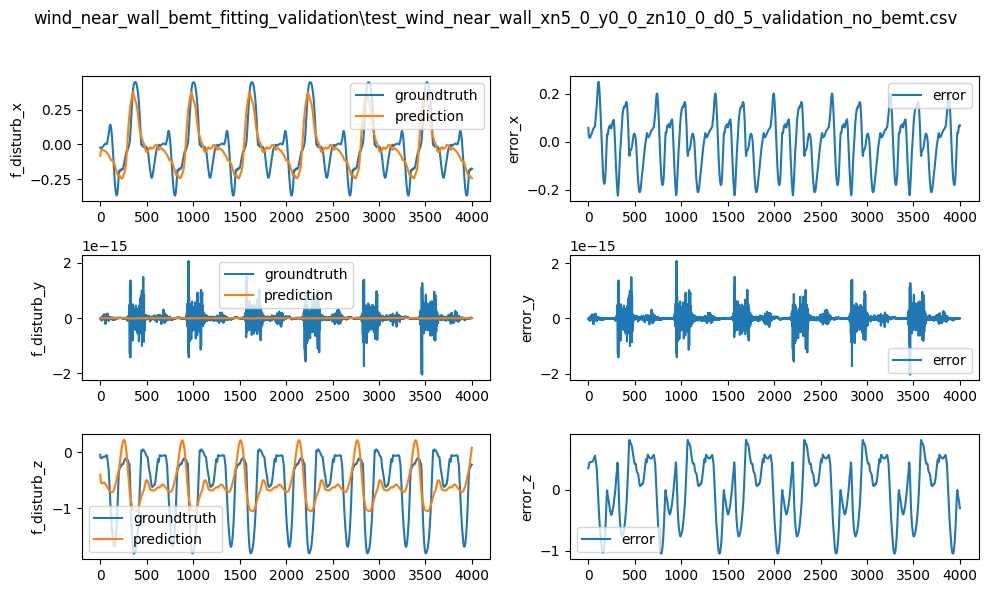

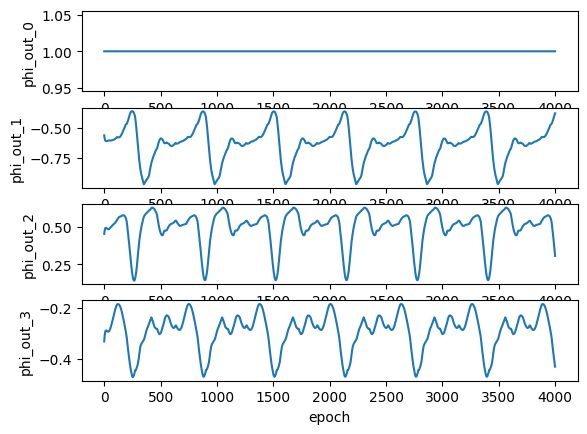

phi_out: tensor([[ 1.0000,  0.1338, -0.4850, -0.3997],
        [ 1.0000,  0.1278, -0.4838, -0.3989],
        [ 1.0000,  0.1229, -0.4832, -0.3985],
        ...,
        [ 1.0000,  0.3309, -0.6782, -0.4083],
        [ 1.0000,  0.3309, -0.6836, -0.4129],
        [ 1.0000,  0.3303, -0.6887, -0.4177]])
a = tensor([[-5.3175e-01,  3.7203e-17, -2.6389e+00],
        [ 3.1455e-01, -2.2455e-17, -5.4107e+00],
        [ 8.9788e-01,  3.3796e-17, -3.7159e+00],
        [-1.7073e+00,  6.7318e-17, -5.0788e-01]])


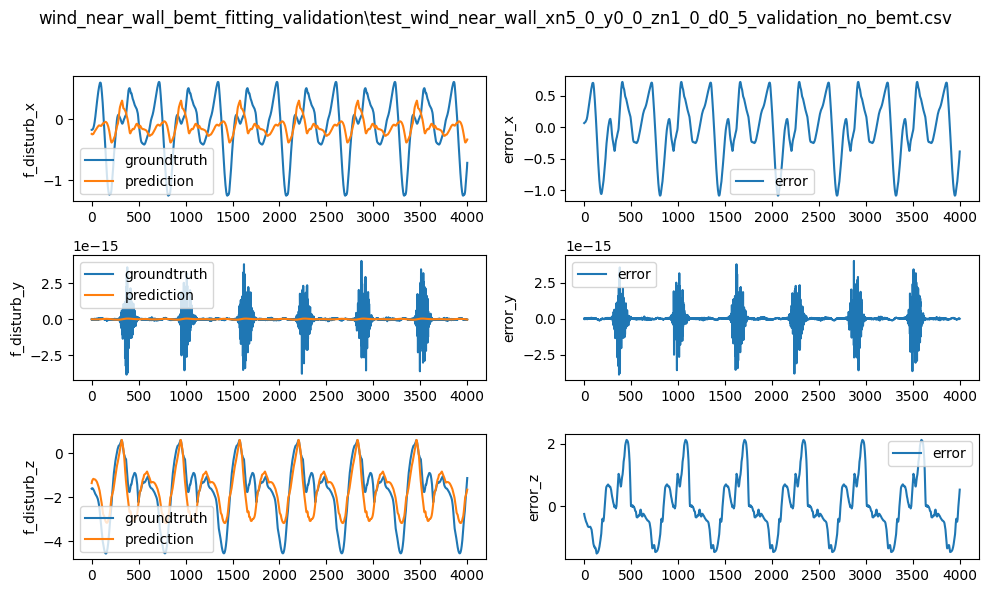

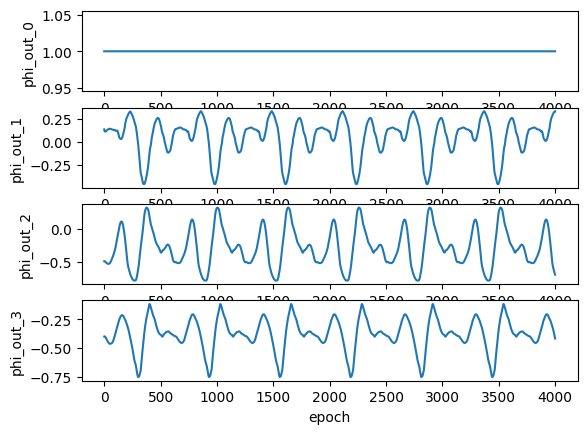

phi_out: tensor([[ 1.0000, -0.0514, -0.1329, -0.3062],
        [ 1.0000, -0.0552, -0.1362, -0.3073],
        [ 1.0000, -0.0584, -0.1388, -0.3081],
        ...,
        [ 1.0000,  0.1119, -0.3380, -0.4411],
        [ 1.0000,  0.1125, -0.3462, -0.4457],
        [ 1.0000,  0.1131, -0.3542, -0.4503]])
a = tensor([[-5.6650e-01,  1.7150e-17, -2.8906e+00],
        [-1.9131e+00,  2.3525e-16,  1.4074e+00],
        [ 3.0352e-01,  3.7558e-17,  1.2503e+00],
        [-4.9493e-01,  3.0866e-17, -5.1712e+00]])


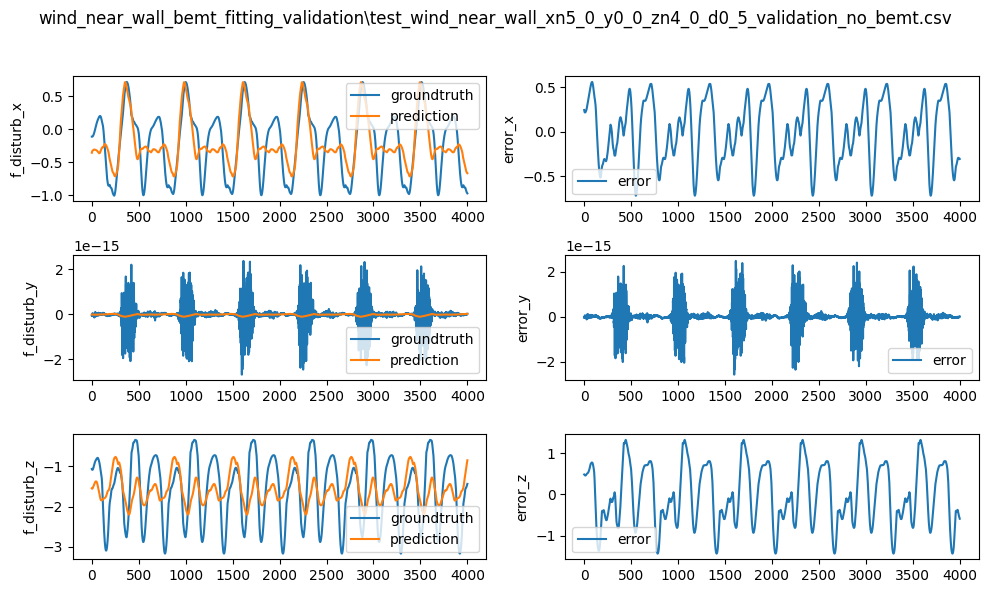

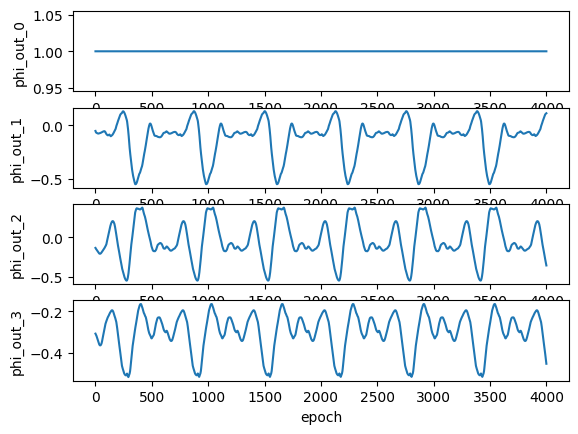

average rms for dim 0: 0.3199082281817059
average rms for dim 1: 1.9636594891945836e-16
average rms for dim 2: 0.6641188660628745


c:\YimingVirtualDDrive\7_workSpace\repo\neural-fly\Simulation\learning\validator.py:153: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


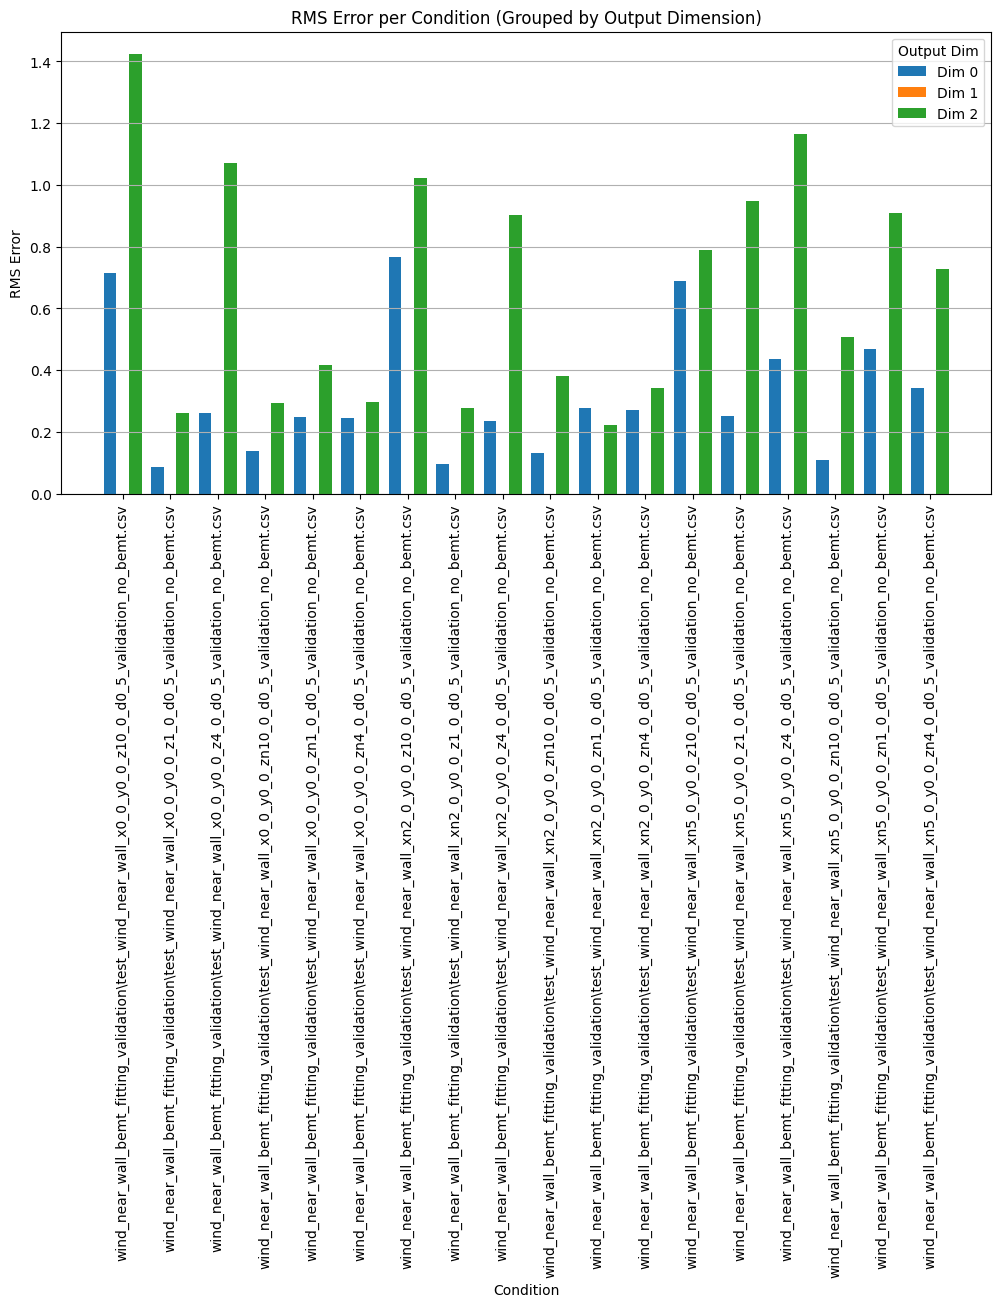

average mse for dim 0: 0.14545288593413475
average mse for dim 1: 6.437446272465949e-32
average mse for dim 2: 0.5737142599285368


c:\YimingVirtualDDrive\7_workSpace\repo\neural-fly\Simulation\learning\validator.py:192: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


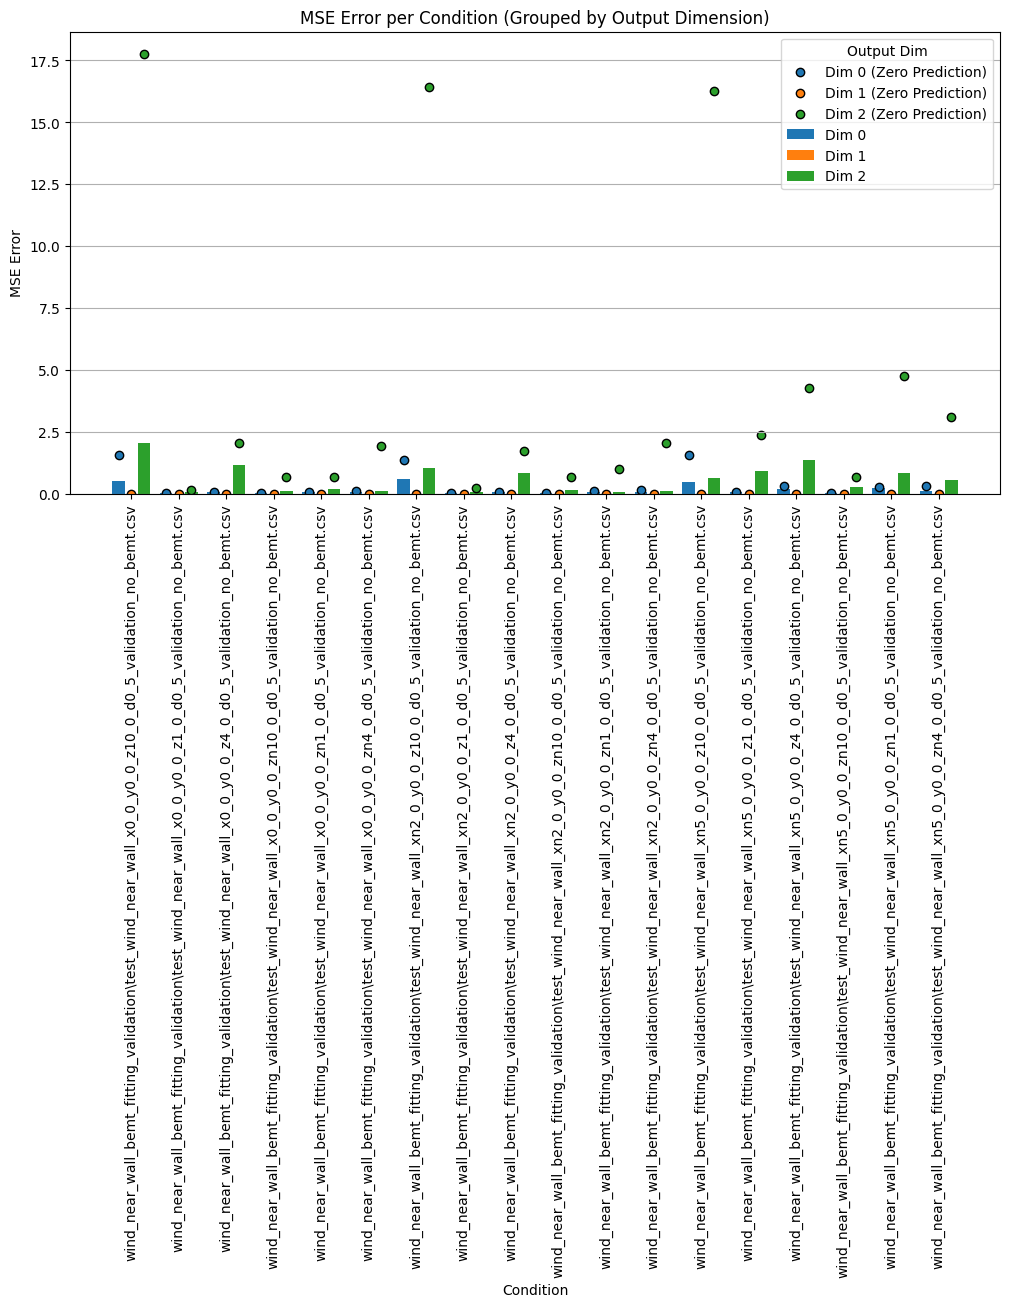

In [5]:
%matplotlib inline
model_name = training_subfolder

subfolder = "wind_near_wall_bemt_fitting_validation"
# subfolder = "nf_validation_back2back"
data_list = generate_data_list(subfolder)
print("test Data List:")
for data in data_list:
    print(data)

# debug
# data_list = data_list[:1]  # use small data list for quick testing

manager = factory.make_test_pipeline()

manager.set_up(
    data_menu=data_list,
    input_label_map_file=path1,
    model_name=model_name
)

# make a new trainer to replicate the above setup, just to allow verify_model to work
manager.test()
plt.show()  
